In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import os
import io
import geopandas as gpd
import seaborn as sns

# suppress warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# data source:

file_path = '/content/drive/My Drive/X999/complaints_2021.csv'

In [69]:
# cleaning functions

# some cleaning ideas are from:
# https://www.kaggle.com/code/riyapatel1697/nyc-311-customer-service-requests-analysis

def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)

def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.strip().str.replace(' ', '_')
    return df

# drop columns that are empty or almost empty
def drop_empty_columns(df):
    # drop columns that are completely or almost empty
    # and get the count of NaNs in each column
    na_col_count = df.isna().sum()
    columns_to_drop = []
    # use .items() instead of .iteritems()
    for column, na_count in na_col_count.items():
      # Check if the column has 85% or more NaNs
        if na_count / len(df) >= 0.85:
            columns_to_drop.append(column)

    df.drop(columns_to_drop, axis=1, inplace=True)  # Drop the columns
    return df

# def drop_unneccessary_columns(df):
#     #drop the unneccesary columns
#     cols = ['x_coordinate_(state_plane)',"agency_name", "agency",
#        'y_coordinate_(state_plane)', 'open_data_channel_type',
#        'park_facility_name', 'park_borough', 'vehicle_type', 'due_date',
#        'taxi_company_borough', 'taxi_pick_up_location', 'bridge_highway_name',
#        'bridge_highway_direction', 'road_ramp', 'bridge_highway_segment','resolution_action_updated_date']
#     df.drop(cols,axis=1,inplace=True)
#     return df

def drop_unneccessary_columns(df):
    columns_to_drop = ['x_coordinate_(state_plane)', 'agency_name', 'agency',
                       'y_coordinate_(state_plane)', 'open_data_channel_type',
                       'park_facility_name', 'park_borough', 'vehicle_type',
                       'due_date', 'taxi_company_borough', 'taxi_pick_up_location',
                       'bridge_highway_name', 'bridge_highway_direction', 'road_ramp',
                       'bridge_highway_segment', 'facility_type', "community_board", "landmark"]

    # Drop the columns from the dataframe, only if they exist
    df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')

    return df_cleaned


In [13]:
complaints_df = pd.read_csv(file_path)

In [59]:
complaints_df.location_type.unique()

array(['Residential Building/House', 'RESIDENTIAL BUILDING',
       '1-2 Family Dwelling', 'Residential Building',
       'Building (Non-Residential)', '3+ Family Apt. Building',
       '1-2 Family Mixed Use Building', '3+ Family Apartment Building',
       '3+ Family Mixed Use Building', '1-3 Family Dwelling',
       'Residential Property', '3+ Family Apt.', '3+ Family Apart',
       '3+ Family Mixed', '1-3 Family Mixed Use Building',
       '1-2 FamilyDwelling', '3+ Family', 'Residential',
       '1/2 Family Dwelling', '3+Family Apt.', '1-2Family Dwelling',
       '3+ Family ApT', '3+ Family Apt', '1-, 2- and 3- Family Home'],
      dtype=object)

In [57]:
# using regex to filter out relevant rows
keywords = r'family|residential'
complaints_df = complaints_df[complaints_df['location_type'].str.contains(keywords, case=False, na=False)]
complaints_df.shape


(991206, 41)

In [53]:
complaints_df = drop_unneccessary_columns(complaints_df)

In [17]:
complaints_df.head(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,48544884,01/01/2021 12:00:00 AM,01/08/2021 12:00:01 AM,DOHMH,Department of Health and Mental Hygiene,Food Poisoning,1 or 2,Restaurant/Bar/Deli/Bakery,11209.0,9208 3 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.619073,-74.032865,"(40.61907281707007, -74.03286537421556)"
1,48537501,01/01/2021 12:00:04 AM,01/01/2021 12:23:27 AM,NYPD,New York City Police Department,Noise - Commercial,Car/Truck Music,Store/Commercial,11209.0,8424 3 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.624794,-74.030527,"(40.62479360728003, -74.03052663868758)"


In [16]:
complaints_df.tail(2)

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
3220913,52935690,12/31/2021 11:59:43 PM,01/01/2022 12:42:07 AM,NYPD,New York City Police Department,Noise - Residential,Loud Music/Party,Residential Building/House,11417.0,105-22 76 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.678764,-73.861304,"(40.67876431813203, -73.86130391198398)"
3220914,52940375,01/01/2022 12:00:00 AM,01/03/2022 08:39:00 AM,DEP,Department of Environmental Protection,Air Quality,"Air: Odor/Fumes, Vehicle Idling (AD3)",NaN,10036.0,640 8 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.756664,-73.990193,"(40.75666417742652, -73.99019293432467)"


In [49]:
# complaints_df = drop_unneccessary_columns(complaints_df)

In [73]:
complaints_df = drop_empty_columns(complaints_df)

In [72]:
complaints_df = clean_column_names(complaints_df)

In [70]:
complaints_df = drop_unneccessary_columns(complaints_df)

In [74]:
complaints_df.shape, \
complaints_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991206 entries, 4 to 3220913
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   unique_key              991206 non-null  int64  
 1   created_date            991206 non-null  object 
 2   closed_date             987353 non-null  object 
 3   complaint_type          991206 non-null  object 
 4   descriptor              979398 non-null  object 
 5   location_type           991206 non-null  object 
 6   incident_zip            991034 non-null  object 
 7   incident_address        991201 non-null  object 
 8   street_name             991201 non-null  object 
 9   cross_street_1          420250 non-null  object 
 10  cross_street_2          420434 non-null  object 
 11  intersection_street_1   420250 non-null  object 
 12  intersection_street_2   420434 non-null  object 
 13  address_type            706947 non-null  object 
 14  city                    

((991206, 22), None)

In [75]:
complaints_df.isna().sum().where(lambda x:x>0).dropna()

,0
closed_date,3853.0
descriptor,11808.0
incident_zip,172.0
incident_address,5.0
street_name,5.0
cross_street_1,570956.0
cross_street_2,570772.0
intersection_street_1,570956.0
intersection_street_2,570772.0
address_type,284259.0


In [77]:
top_50_complaints = complaints_df['complaint_type'].value_counts().nlargest(50).index
complaints_df_top50 = complaints_df[complaints_df['complaint_type'].isin(top_50_complaints)]


In [79]:
complaints_df_top50.shape

(991206, 22)

In [80]:
# drop rows that have NaN in geo data columns
complaints_df_top50 = complaints_df_top50.dropna(subset=['latitude', 'longitude'])

In [83]:
complaints_df_top50.shape

(990208, 22)

In [82]:
complaints_df_top50_cleaned = complaints_df_top50.dropna()

In [84]:
complaints_df_top50_cleaned.shape

(125505, 22)

In [87]:
complaints_df_top50_cleaned.created_date =  pd.to_datetime(complaints_df_top50_cleaned.created_date)

In [88]:
complaints_df_top50_cleaned.closed_date =  pd.to_datetime(complaints_df_top50_cleaned.closed_date)

In [89]:
complaints_df_top50_cleaned.created_date.min(), complaints_df_top50_cleaned.created_date.max(), \
complaints_df_top50_cleaned.closed_date.min(), complaints_df_top50_cleaned.closed_date.max()

# amazing

(Timestamp('2021-01-01 01:37:50'),
 Timestamp('2021-12-31 23:59:38'),
 Timestamp('2021-01-01 12:05:11'),
 Timestamp('2024-06-04 03:54:06'))

In [90]:
complaints_df.columns

Index(['unique_key', 'created_date', 'closed_date', 'complaint_type',
       'descriptor', 'location_type', 'incident_zip', 'incident_address',
       'street_name', 'cross_street_1', 'cross_street_2',
       'intersection_street_1', 'intersection_street_2', 'address_type',
       'city', 'status', 'resolution_description', 'bbl', 'borough',
       'latitude', 'longitude', 'location'],
      dtype='object')

In [92]:
complaints_df_top50_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 125505 entries, 704 to 3220911
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   unique_key              125505 non-null  int64         
 1   created_date            125505 non-null  datetime64[ns]
 2   closed_date             125505 non-null  datetime64[ns]
 3   complaint_type          125505 non-null  object        
 4   descriptor              125505 non-null  object        
 5   location_type           125505 non-null  object        
 6   incident_zip            125505 non-null  object        
 7   incident_address        125505 non-null  object        
 8   street_name             125505 non-null  object        
 9   cross_street_1          125505 non-null  object        
 10  cross_street_2          125505 non-null  object        
 11  intersection_street_1   125505 non-null  object        
 12  intersection_street_2   125505 n

In [93]:
print(complaints_df_top50_cleaned.isnull().sum())

unique_key                0
created_date              0
closed_date               0
complaint_type            0
descriptor                0
location_type             0
incident_zip              0
incident_address          0
street_name               0
cross_street_1            0
cross_street_2            0
intersection_street_1     0
intersection_street_2     0
address_type              0
city                      0
status                    0
resolution_description    0
bbl                       0
borough                   0
latitude                  0
longitude                 0
location                  0
dtype: int64


In [99]:
complaints_df_top50_cleaned.head(1)

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,intersection_street_2,address_type,city,status,resolution_description,bbl,borough,latitude,longitude,location
704,48537000,2021-01-01 01:37:50,2021-01-03 10:48:53,Indoor Air Quality,Ventilation,1-2 Family Dwelling,10312.0,677 LEVERETT AVENUE,LEVERETT AVENUE,RICHMOND AVENUE,...,WAINWRIGHT AVENUE,ADDRESS,STATEN ISLAND,Closed,The NYC Health Department (DOHMH) found a serv...,5.056090e+09,STATEN ISLAND,40.554716,-74.169599,"(40.55471571649305, -74.16959899090088)"


In [104]:
complaints_df_top50_cleaned.loc[complaints_df_top50_cleaned.status.isin(['open','assigned','draft']),'status'] = 'closed'

In [105]:
city = complaints_df_top50_cleaned.city.mode()[0]
zipcode = complaints_df_top50_cleaned.loc[complaints_df_top50_cleaned.city == city,'incident_zip'].mode()[0]
latitude = complaints_df_top50_cleaned.loc[complaints_df_top50_cleaned['incident_zip'] == zipcode,'latitude'].mode()[0]
longitude = complaints_df_top50_cleaned.loc[complaints_df_top50_cleaned['incident_zip'] == zipcode,'longitude'].mode()[0]
#fill zipcode,latitude and longitude with modevalues where city is empty and then update city value to mode value
complaints_df_top50_cleaned.loc[complaints_df_top50_cleaned.city.isna(),'incident_zip'] = zipcode
complaints_df_top50_cleaned.loc[complaints_df_top50_cleaned.city.isna(),'city'] = city
complaints_df_top50_cleaned.loc[(complaints_df_top50_cleaned.city == city) & (complaints_df_top50_cleaned.latitude.isna()==True),'latitude'] = latitude
complaints_df_top50_cleaned.loc[(complaints_df_top50_cleaned.city == city) & (complaints_df_top50_cleaned.longitude.isna()==True),'longitude'] = longitude

In [106]:
complaints_df_top50_cleaned.shape

(125505, 22)

In [107]:
complaints_df_top50_cleaned.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,intersection_street_2,address_type,city,status,resolution_description,bbl,borough,latitude,longitude,location
704,48537000,2021-01-01 01:37:50,2021-01-03 10:48:53,Indoor Air Quality,Ventilation,1-2 Family Dwelling,10312.0,677 LEVERETT AVENUE,LEVERETT AVENUE,RICHMOND AVENUE,...,WAINWRIGHT AVENUE,ADDRESS,STATEN ISLAND,Closed,The NYC Health Department (DOHMH) found a serv...,5.056090e+09,STATEN ISLAND,40.554716,-74.169599,"(40.55471571649305, -74.16959899090088)"
710,48539995,2021-01-01 01:38:40,2024-06-04 03:54:06,Smoking,Smoking Violation,Residential Building,11230.0,1615 AVENUE I,AVENUE I,EAST 16 STREET,...,EAST 17 STREET,ADDRESS,BROOKLYN,Closed,This SR was administratively closed. The issue...,3.067000e+09,BROOKLYN,40.627709,-73.960678,"(40.62770864761391, -73.96067821349067)"
1266,48547550,2021-01-01 03:20:28,2024-06-04 03:54:05,Smoking,Smoking Violation,Residential Building,10472.0,1750 EAST 172 STREET,EAST 172 STREET,ROSEDALE AVENUE,...,COMMONWEALTH AVENUE,ADDRESS,BRONX,Closed,This SR was administratively closed. The issue...,2.037840e+09,BRONX,40.832625,-73.868901,"(40.83262456596203, -73.86890067543244)"
1307,48544890,2021-01-01 03:31:37,2021-01-03 10:48:21,Indoor Air Quality,Ventilation,1-2 Family Dwelling,10312.0,677 LEVERETT AVENUE,LEVERETT AVENUE,RICHMOND AVENUE,...,WAINWRIGHT AVENUE,ADDRESS,STATEN ISLAND,Closed,The NYC Health Department (DOHMH) found a serv...,5.056090e+09,STATEN ISLAND,40.554716,-74.169599,"(40.55471571649305, -74.16959899090088)"
1397,48546400,2021-01-01 03:54:31,2024-06-04 03:54:04,Smoking,Smoking Violation,Residential Building,11220.0,553 58 STREET,58 STREET,5 AVENUE,...,6 AVENUE,ADDRESS,BROOKLYN,Closed,This SR was administratively closed. The issue...,3.008480e+09,BROOKLYN,40.639937,-74.013826,"(40.639937080853905, -74.01382550066872)"


In [109]:
complaints_df_top50_cleaned.shape

(125505, 22)

In [110]:
len(complaints_df_top50_cleaned.complaint_type.unique())

20

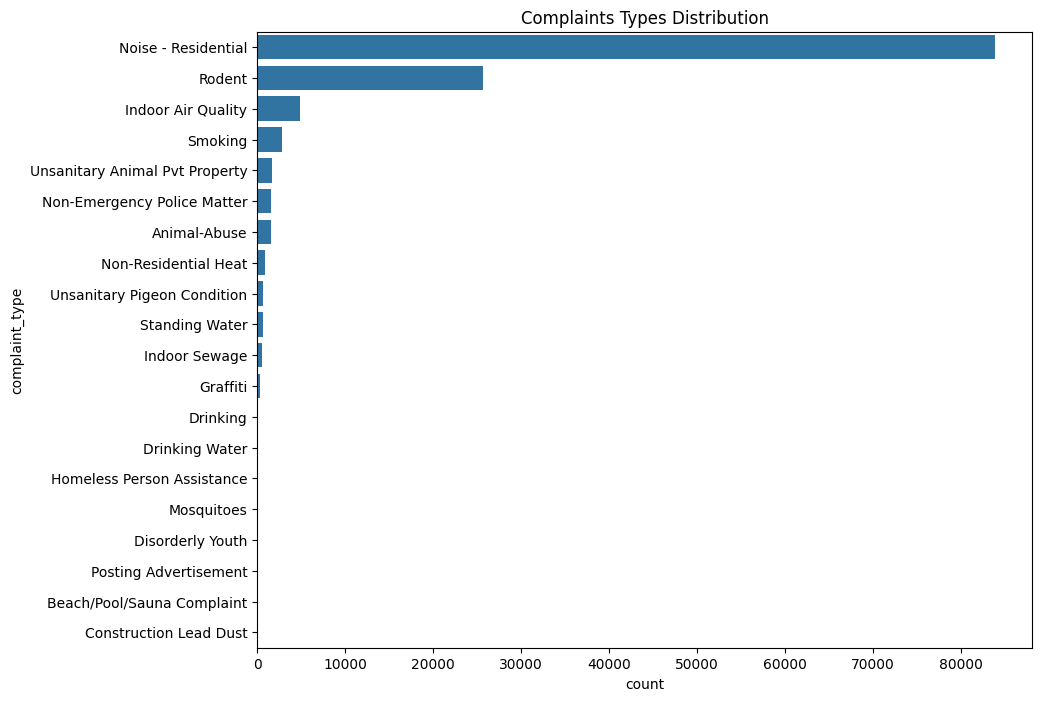

In [113]:
# print(complaints_df_top50_cleaned.complaint_type.unique())
# plt.figure(figsize=(10,8))
# plt.title('Complaints Types Distribution')
# sns.countplot(y='complaint_type', data=complaints_df_top50_cleaned)
# plt.show()
# in descending order
complaint_order = complaints_df_top50_cleaned['complaint_type'].value_counts().index
plt.figure(figsize=(10,8))
plt.title('Complaints Types Distribution')
sns.countplot(y='complaint_type', data=complaints_df_top50_cleaned, order=complaint_order)
plt.show()


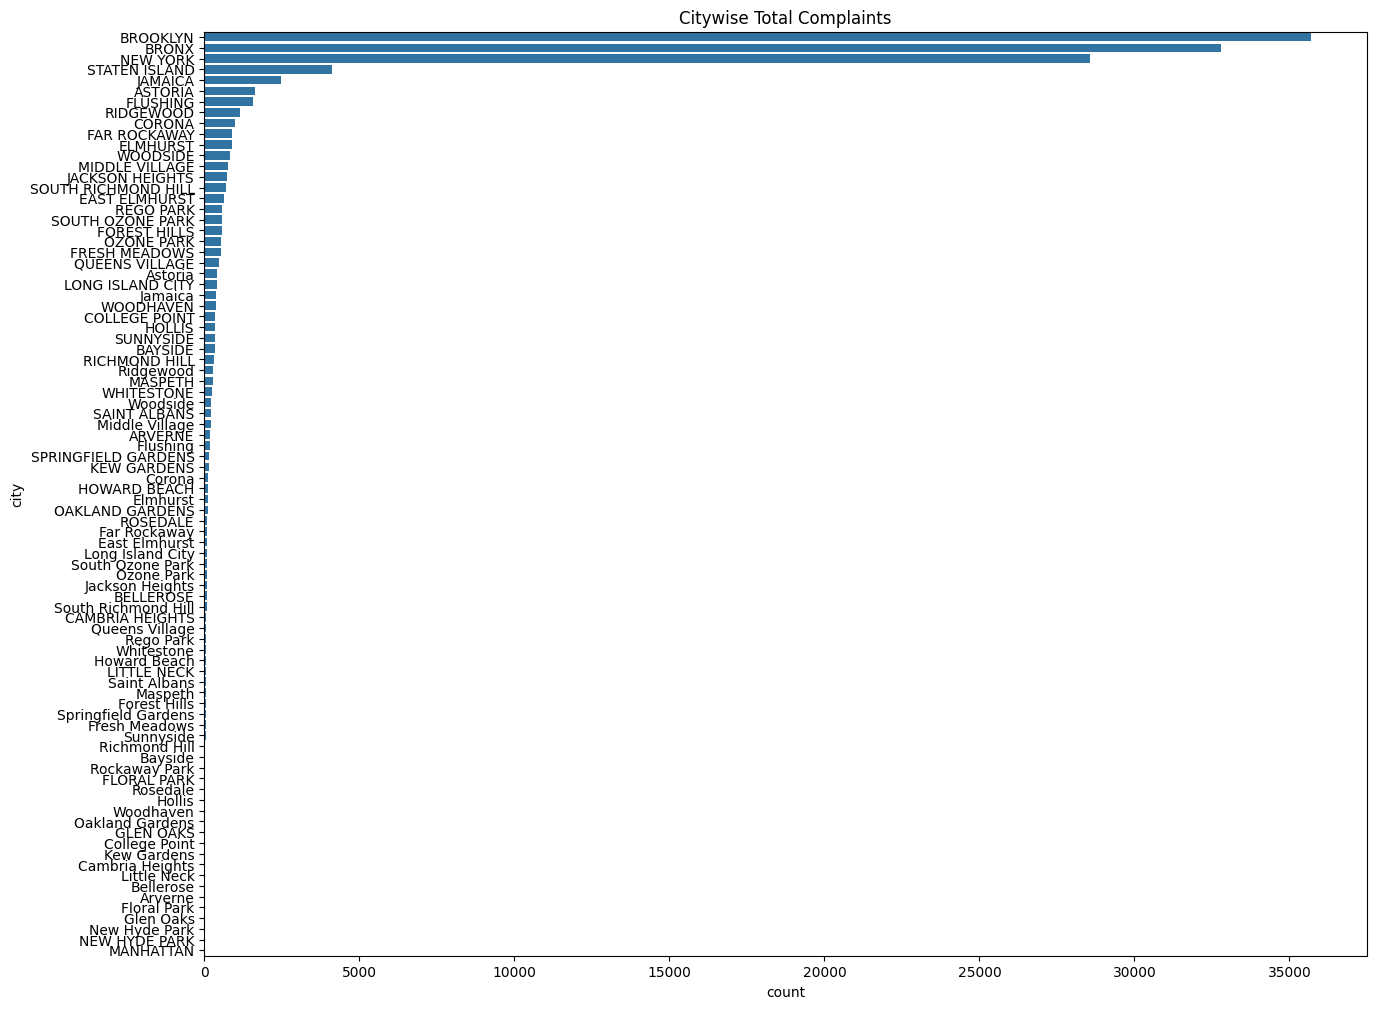

In [117]:
city_order = complaints_df_top50_cleaned['city'].value_counts().index
plt.figure(figsize=(15,12))
plt.title('Citywise Total Complaints')
sns.countplot(y='city', data=complaints_df_top50_cleaned, order=city_order)
plt.show()


In [119]:
top5cities = complaints_df_top50_cleaned['city'].value_counts().head(5).index.to_list()
dstop5 = complaints_df_top50_cleaned[complaints_df_top50_cleaned.city.isin(top5cities)]
#citywise complaint counts(typewise)
df1 = pd.crosstab(dstop5['city'],dstop5['complaint_type'])

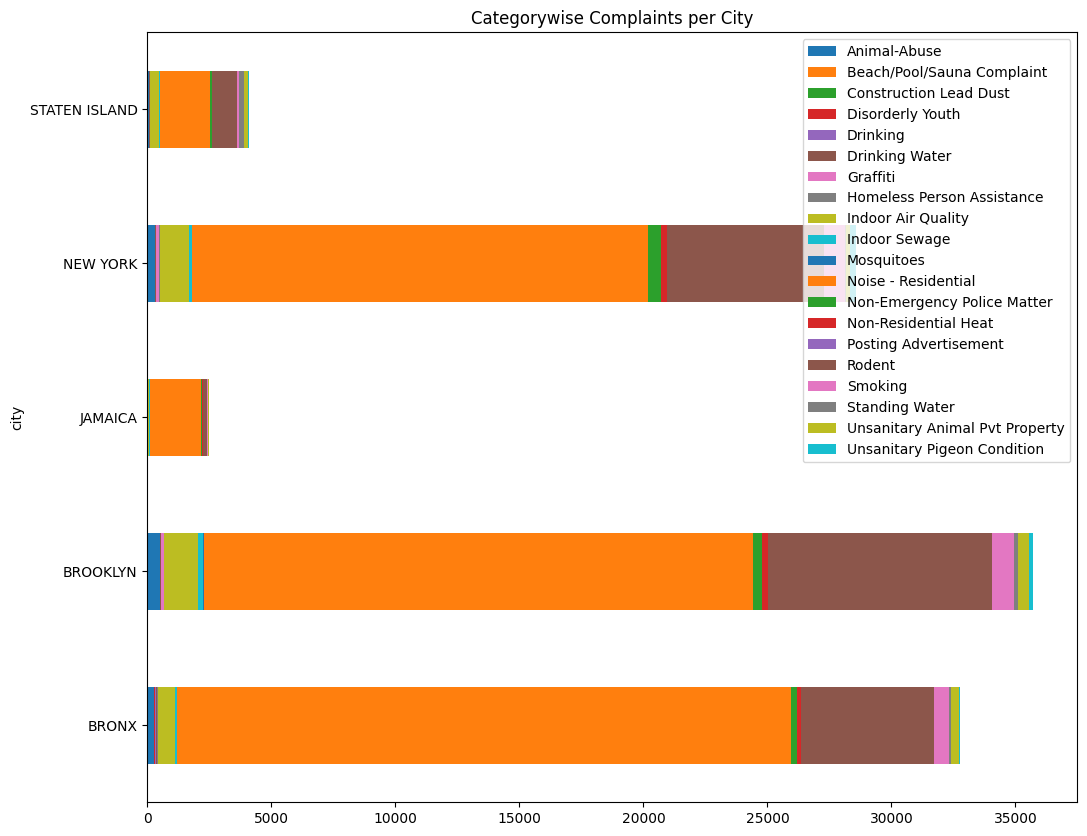

In [121]:
# Categorywise Complaints per City re-org
# df1.plot(kind='barh',stacked=True,figsize=(12,10))
# plt.title('Categorywise Complaints per city')
# plt.show()

df1.plot(kind='barh', stacked=True, figsize=(12,10))
plt.title('Categorywise Complaints per City')
plt.legend(loc='upper right')
plt.show()


In [111]:
# save cleaned 311 complaints data to my drive
complaints_df_top50_cleaned.to_csv('/content/drive/My Drive/X999/complaints_df_clean2021.csv', index=False)

In [112]:
complaints_df_top50_cleaned.head()

,unique_key,created_date,closed_date,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,cross_street_1,...,intersection_street_2,address_type,city,status,resolution_description,bbl,borough,latitude,longitude,location
704,48537000,2021-01-01 01:37:50,2021-01-03 10:48:53,Indoor Air Quality,Ventilation,1-2 Family Dwelling,10312.0,677 LEVERETT AVENUE,LEVERETT AVENUE,RICHMOND AVENUE,...,WAINWRIGHT AVENUE,ADDRESS,STATEN ISLAND,Closed,The NYC Health Department (DOHMH) found a serv...,5.056090e+09,STATEN ISLAND,40.554716,-74.169599,"(40.55471571649305, -74.16959899090088)"
710,48539995,2021-01-01 01:38:40,2024-06-04 03:54:06,Smoking,Smoking Violation,Residential Building,11230.0,1615 AVENUE I,AVENUE I,EAST 16 STREET,...,EAST 17 STREET,ADDRESS,BROOKLYN,Closed,This SR was administratively closed. The issue...,3.067000e+09,BROOKLYN,40.627709,-73.960678,"(40.62770864761391, -73.96067821349067)"
1266,48547550,2021-01-01 03:20:28,2024-06-04 03:54:05,Smoking,Smoking Violation,Residential Building,10472.0,1750 EAST 172 STREET,EAST 172 STREET,ROSEDALE AVENUE,...,COMMONWEALTH AVENUE,ADDRESS,BRONX,Closed,This SR was administratively closed. The issue...,2.037840e+09,BRONX,40.832625,-73.868901,"(40.83262456596203, -73.86890067543244)"
1307,48544890,2021-01-01 03:31:37,2021-01-03 10:48:21,Indoor Air Quality,Ventilation,1-2 Family Dwelling,10312.0,677 LEVERETT AVENUE,LEVERETT AVENUE,RICHMOND AVENUE,...,WAINWRIGHT AVENUE,ADDRESS,STATEN ISLAND,Closed,The NYC Health Department (DOHMH) found a serv...,5.056090e+09,STATEN ISLAND,40.554716,-74.169599,"(40.55471571649305, -74.16959899090088)"
1397,48546400,2021-01-01 03:54:31,2024-06-04 03:54:04,Smoking,Smoking Violation,Residential Building,11220.0,553 58 STREET,58 STREET,5 AVENUE,...,6 AVENUE,ADDRESS,BROOKLYN,Closed,This SR was administratively closed. The issue...,3.008480e+09,BROOKLYN,40.639937,-74.013826,"(40.639937080853905, -74.01382550066872)"
